In [1]:
from tqdm import tqdm
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
OUTPUT_DIR = "./output/"

In [2]:
cube_img = cv2.imread("output/cube_map.png")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def create_3dmap_from_size_torch(img_w, img_h, device):
    h = torch.linspace(-np.pi/2, np.pi/2, img_h, device=device)
    w = torch.linspace(-np.pi, np.pi, img_w, device=device)
    
    h += (np.pi/2) / img_h
    w += np.pi / img_w
    
    theta, phi = torch.meshgrid(w, h, indexing="ij")
    
    x = torch.cos(phi) * torch.cos(theta)
    y = torch.cos(phi) * torch.sin(theta)
    z = torch.sin(phi)
    #print(x, y,z)
    
    return x, y, z

In [55]:
def padding_cube(img, pad_w, device):
    img_tensor = torch.tensor(img).to(device)#.permute(0, 1, pad_w)
    
    h, w, c = img_tensor.shape
    cw = w // 4
    #print(h, w, c)

    
    canvas = torch.zeros((h+pad_w*2, w+pad_w*2, c), dtype=img_tensor.dtype, device=device)
    canvas[pad_w:-pad_w, pad_w:-pad_w,:] = img_tensor
    
    # up    
    canvas[0:pad_w, cw+pad_w:2*cw+pad_w,:] = torch.rot90(img_tensor[cw:cw+pad_w, 3*cw:,:], 2, [0,1])
    # bottom
    canvas[-pad_w:, cw+pad_w:2*cw+pad_w,:] = torch.rot90(img_tensor[2*cw-pad_w:2*cw, 3*cw:,:], 2, [0,1])
    # left
    canvas[cw+pad_w:2*cw+pad_w, 0:pad_w,:] = img_tensor[cw:2*cw, -pad_w:,:]
    # right
    canvas[cw+pad_w:2*cw+pad_w, -pad_w:,:] = img_tensor[cw:2*cw, 0:pad_w,:]

    canvas[cw:cw+pad_w, :cw+pad_w,:] = torch.rot90(canvas[:cw+pad_w, cw+pad_w:cw+pad_w*2,:], 1, [0,1])
    canvas[:cw+pad_w, cw:cw+pad_w,:] = torch.rot90(canvas[cw+pad_w:cw+pad_w*2, :cw+pad_w,:], 3, [0,1])
    canvas[2*cw+pad_w:2*cw+pad_w*2, :cw+pad_w,:] = torch.rot90(canvas[2*cw+pad_w:, cw+pad_w:cw+pad_w*2,:], 3, [0,1])
    canvas[2*cw+pad_w:, cw:cw+pad_w,:] = torch.rot90(canvas[2*cw:2*cw+pad_w, :cw+pad_w,:], 1, [0,1])
    canvas[cw:cw+pad_w, 2*cw+pad_w:3*cw+pad_w*2,:] = torch.rot90(canvas[:cw+pad_w, 2*cw:2*cw+pad_w,:], 3, [0,1])
    canvas[:cw+pad_w, 2*cw+pad_w:2*cw+pad_w*2,:] = torch.rot90(canvas[cw+pad_w:cw+pad_w*2, 2*cw+pad_w:3*cw+pad_w*2,:], 1, [0,1])
    canvas[2*cw+pad_w:2*cw+pad_w*2, 2*cw+pad_w:3*cw+pad_w,:] = torch.rot90(canvas[2*cw+pad_w:-pad_w, 2*cw:2*cw+pad_w,:], 1, [0,1])
    canvas[2*cw+pad_w:, 2*cw+pad_w:2*cw+pad_w*2,:] = torch.rot90(canvas[2*cw:2*cw+pad_w, 2*cw+pad_w:3*cw+pad_w*2,:], 3, [0,1])

    canvas[cw:cw+pad_w, 3*cw+pad_w:4*cw+pad_w*2,:] = torch.rot90(canvas[0:pad_w, cw+pad_w:2*cw+pad_w*2,:], 2, [0,1])
    canvas[2*cw+pad_w:2*cw+pad_w*2, 3*cw+pad_w:4*cw+pad_w*2,:] = torch.rot90(canvas[-pad_w:, cw+pad_w:2*cw+pad_w*2,:], 2, [0,1])

    return canvas

In [56]:
def cube_to_equirectangular_torch(img, width, pad_width, device):
    img_tensor = torch.tensor(img, device=device).float()

    img_w = width
    img_h = width // 2
    width = img_tensor.shape[1] // 4
    print(img_h, img_w, width)

    x, y, z = create_3dmap_from_size_torch(img_w, img_h, device)

    w = 0.5

    # front
    xx = w*y / x + w
    yy = w*z / x + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (x > 0)
    tmpx = torch.where(mask, xx*width + width, 0)
    tmpy = torch.where(mask, yy*width + width, 0)
     
    # back
    xx = w*y / x + w
    yy = -w*z / x + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (x < 0)
    tmpx = torch.where(mask, xx*width + width*3, tmpx)
    tmpy = torch.where(mask, yy*width + width, tmpy)
     
    #right
    xx = -w*x / y + w
    yy = w*z / y + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (y > 0)
    tmpx = torch.where(mask, xx*width + width*2, tmpx)
    tmpy = torch.where(mask, yy*width + width, tmpy)
     
    #left
    xx = -w*x / y + w
    yy = -w*z / y + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (y < 0)
    tmpx = torch.where(mask, xx*width, tmpx)
    tmpy = torch.where(mask, yy*width + width, tmpy)
     
    #up
    xx = -w*y / z + w
    yy = -w*x / z + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (z < 0)
    tmpx = torch.where(mask, xx*width + width, tmpx)
    tmpy = torch.where(mask, yy*width, tmpy)
     
    #bottom
    xx = w*y / z + w
    yy = -w*x / z + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (z > 0)
    tmpx = torch.where(mask, xx*width + width, tmpx)
    tmpy = torch.where(mask, yy*width + width*2, tmpy)

    cube = padding_cube(img, pad_width, device)
    # Offset
    tmpx += (pad_width - 0.5)
    tmpy += (pad_width - 0.5)
    
    cube_np = cube.cpu().numpy()
    tmpx_np = tmpx.cpu().numpy().astype(np.float32)
    tmpy_np = tmpy.cpu().numpy().astype(np.float32)

    ret_img = cv2.remap(cube_np, tmpx_np, tmpy_np, interpolation=cv2.INTER_LINEAR)
    ret_img = cv2.rotate(ret_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    ret_img = cv2.flip(ret_img, 0)
    
    return ret_img

In [57]:
cube_img = cv2.imread("output/cube_map.png")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(cube_img.shape)
immm = padding_cube(cube_img, 50, device)
cv2.imwrite("aaa.png", immm.cpu().numpy())

(2880, 3840, 3)


True

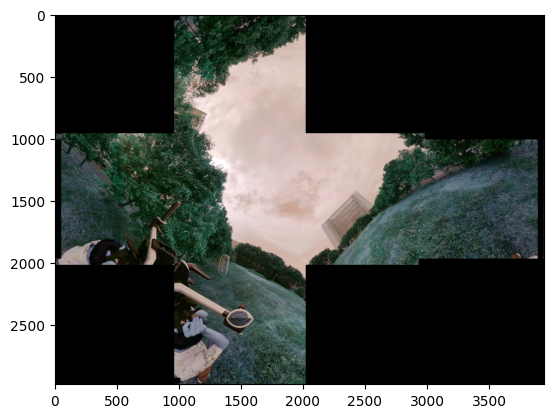

In [13]:
import matplotlib.pyplot as plt
plt.imshow(immm.cpu().numpy())
plt.show()